# Part 2 — Sweep Speed & Measurement Quality Testing

**Assignment:** LibreVNA Validation Test — Part 2

## Objectives
- **(a) Sweep Speed Baseline:** Record ≥ 30 consecutive sweep times at IFBW 50 kHz (300 pts, 2.43–2.45 GHz). Compute mean, std, min, max.
- **(b) IFBW Parameter Sweep:** Vary IFBW across 50 kHz, 10 kHz, 1 kHz. For each, record sweep time, update rate, S11 noise floor, and trace jitter.

## Device under test
| Field | Value |
|---|---|
| Device | LibreVNA |
| Serial | 206830535532 |
| Firmware | v1.6.4 |
| Calibration | SOLT_1 (2.43–2.45 GHz, 300 pts) |
| DUT on Port 1 | Calibrated 50 Ω termination load |

## Notebook workflow
1. **Cell 2** – Imports and path setup
2. **Cell 3** – Load Part 2(a) sweep-speed baseline data from CSV
3. **Cell 4** – Sweep-time time-series + histogram
4. **Cell 5** – Part 2(a) summary table (PrettyTable)
5. **Cell 6** – Part 2(a) analysis: polling-granularity effect
6. **Cell 7** – Load Part 2(b) IFBW trace data from CSVs
7. **Cell 8** – Overlay plot: mean S11 traces for each IFBW
8. **Cell 9** – Jitter analysis plot (per-point std across sweeps)
9. **Cell 10** – Part 2(b) comparison table (PrettyTable)
10. **Cell 11** – Combined conclusions

In [1]:
# ---------------------------------------------------------------------------
# Cell 2  --  Imports and path setup
# ---------------------------------------------------------------------------
import sys
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable

# ---------------------------------------------------------------------------
# Absolute paths
# ---------------------------------------------------------------------------
SCRIPTS_DIR = (
    "/home/user/jeffrymahbuubi/PROJECTS/"
    "7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/scripts"
)
DATA_DIR = (
    "/home/user/jeffrymahbuubi/PROJECTS/"
    "7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data"
)

sys.path.insert(0, SCRIPTS_DIR)
os.makedirs(DATA_DIR, exist_ok=True)

print(f"SCRIPTS_DIR : {SCRIPTS_DIR}")
print(f"DATA_DIR    : {DATA_DIR}")
print(f"numpy       : {np.__version__}")
print(f"matplotlib  : {plt.matplotlib.__version__}")
print(f"pandas      : {pd.__version__}")

SCRIPTS_DIR : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/scripts
DATA_DIR    : /home/user/jeffrymahbuubi/PROJECTS/7-LibreVNA-Vector-Network-Analyzer/code/LibreVNA-dev/data
numpy       : 2.2.6
matplotlib  : 3.10.8
pandas      : 2.3.3


In [2]:
# ---------------------------------------------------------------------------
# Cell 3  --  Load Part 2(a) sweep-speed baseline data
# ---------------------------------------------------------------------------

# --- Timing records ---------------------------------------------------------
timing_candidates = sorted(glob.glob(os.path.join(DATA_DIR, "sweep_speed_baseline_*.csv")))
if not timing_candidates:
    raise FileNotFoundError("No sweep_speed_baseline_*.csv found. Run 3_sweep_speed_baseline.py first.")
latest_timing_csv = timing_candidates[-1]
df_timing = pd.read_csv(latest_timing_csv)

sweep_numbers  = df_timing["Sweep_Number"].to_numpy(dtype=int)
sweep_times    = df_timing["Sweep_Time_s"].to_numpy(dtype=np.float64)
update_rates   = df_timing["Update_Rate_Hz"].to_numpy(dtype=np.float64)

print(f"Loaded timing : {os.path.basename(latest_timing_csv)}")
print(f"  Sweeps      : {len(sweep_times)}")
print(f"  Time range  : {sweep_times.min():.4f} s – {sweep_times.max():.4f} s")

# --- Last S11 trace ---------------------------------------------------------
trace_candidates = sorted(glob.glob(os.path.join(DATA_DIR, "sweep_speed_last_trace_*.csv")))
if not trace_candidates:
    raise FileNotFoundError("No sweep_speed_last_trace_*.csv found.")
latest_trace_csv = trace_candidates[-1]
df_trace = pd.read_csv(latest_trace_csv)

freq_hz_baseline = df_trace["Frequency_Hz"].to_numpy(dtype=np.float64)
s11_db_baseline  = df_trace["S11_dB"].to_numpy(dtype=np.float64)

print(f"Loaded trace  : {os.path.basename(latest_trace_csv)}")
print(f"  Points      : {len(freq_hz_baseline)}")

Loaded timing : sweep_speed_baseline_20260204_201933.csv
  Sweeps      : 30
  Time range  : 0.1937 s – 0.1978 s
Loaded trace  : sweep_speed_last_trace_20260204_201933.csv
  Points      : 300


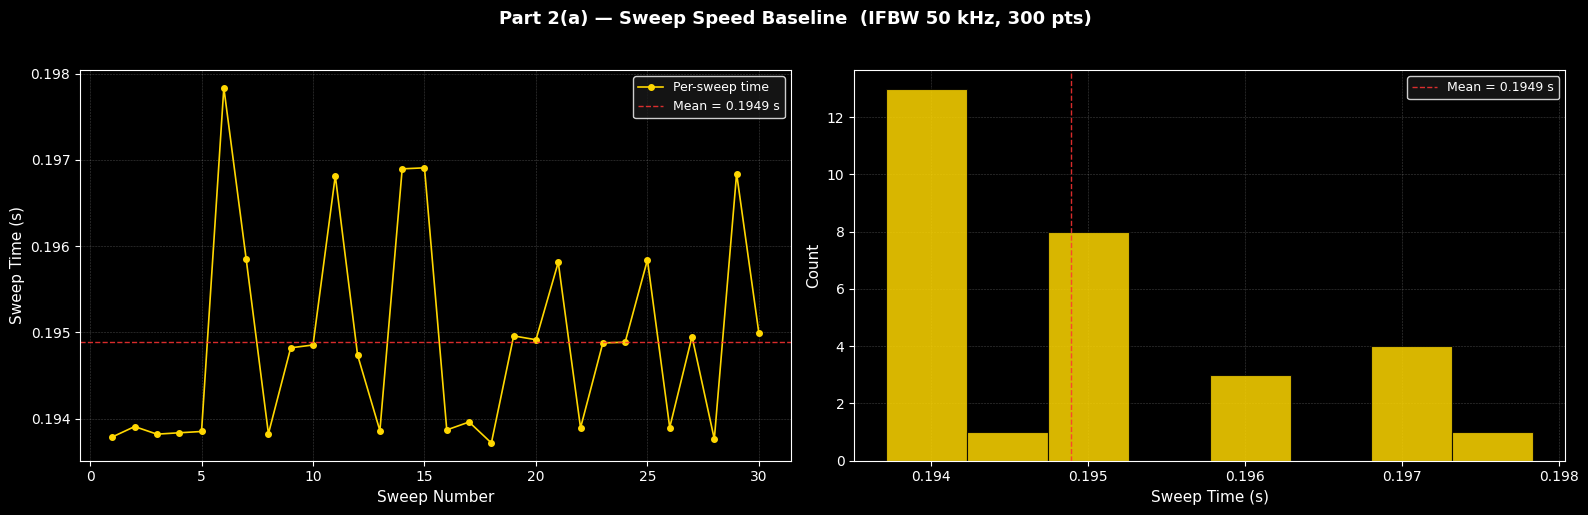

In [3]:
# ---------------------------------------------------------------------------
# Cell 4  --  Sweep-time time-series and histogram
# ---------------------------------------------------------------------------

plt.style.use("dark_background")
TRACE_COLOR  = "#FFD700"
REF_COLOR    = "#FF3333"

mean_time = float(np.mean(sweep_times))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.patch.set_facecolor("black")
fig.suptitle("Part 2(a) — Sweep Speed Baseline  (IFBW 50 kHz, 300 pts)",
             color="white", fontsize=13, fontweight="bold", y=1.02)

# ---- Left: time series --------------------------------------------------
ax = axes[0]
ax.set_facecolor("black")
ax.plot(sweep_numbers, sweep_times, color=TRACE_COLOR, linewidth=1.2,
        marker="o", markersize=4, label="Per-sweep time")
ax.axhline(mean_time, color=REF_COLOR, linewidth=1.0, linestyle="--",
           alpha=0.85, label=f"Mean = {mean_time:.4f} s")
ax.set_xlabel("Sweep Number", color="white", fontsize=11)
ax.set_ylabel("Sweep Time (s)", color="white", fontsize=11)
ax.tick_params(colors="white")
ax.legend(fontsize=9, facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

# ---- Right: histogram ----------------------------------------------------
ax = axes[1]
ax.set_facecolor("black")
ax.hist(sweep_times, bins=8, color=TRACE_COLOR, edgecolor="black",
        linewidth=0.8, alpha=0.85)
ax.axvline(mean_time, color=REF_COLOR, linewidth=1.0, linestyle="--",
           alpha=0.85, label=f"Mean = {mean_time:.4f} s")
ax.set_xlabel("Sweep Time (s)", color="white", fontsize=11)
ax.set_ylabel("Count", color="white", fontsize=11)
ax.tick_params(colors="white")
ax.legend(fontsize=9, facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [4]:
# ---------------------------------------------------------------------------
# Cell 5  --  Part 2(a) summary (PrettyTable)
# ---------------------------------------------------------------------------

# ---- Table 1: timing statistics ------------------------------------------
t1 = PrettyTable()
t1.field_names = ["Metric", "Mean", "Std Dev", "Min", "Max"]
t1.add_row([
    "Sweep Time (s)",
    f"{np.mean(sweep_times):.4f}",
    f"{np.std(sweep_times, ddof=1):.4f}",
    f"{np.min(sweep_times):.4f}",
    f"{np.max(sweep_times):.4f}"
])
t1.add_row([
    "Update Rate (Hz)",
    f"{np.mean(update_rates):.2f}",
    f"{np.std(update_rates, ddof=1):.2f}",
    f"{np.min(update_rates):.2f}",
    f"{np.max(update_rates):.2f}"
])
print("Part 2(a) — Timing Statistics")
print(t1)

# ---- Table 2: target assessment ------------------------------------------
mean_rate = float(np.mean(update_rates))
status = "MEETS TARGET" if mean_rate >= 25.0 else "BELOW TARGET"

t2 = PrettyTable()
t2.field_names = ["Parameter", "Value"]
t2.add_row(["Target Update Rate",    "25.0 Hz"])
t2.add_row(["Measured Mean Rate",    f"{mean_rate:.2f} Hz"])
t2.add_row(["Status",                status])
t2.add_row(["LibreVNA Spec (raw)",   "10 k points/s @ 50 kHz IFBW"])
t2.add_row(["Polling Interval",      "0.01 s (SCPI ACQ:FIN? loop)"])
print("\nTarget Assessment")
print(t2)

Part 2(a) — Timing Statistics
+------------------+--------+---------+--------+--------+
|      Metric      |  Mean  | Std Dev |  Min   |  Max   |
+------------------+--------+---------+--------+--------+
|  Sweep Time (s)  | 0.1949 |  0.0012 | 0.1937 | 0.1978 |
| Update Rate (Hz) |  5.13  |   0.03  |  5.05  |  5.16  |
+------------------+--------+---------+--------+--------+

Target Assessment
+---------------------+-----------------------------+
|      Parameter      |            Value            |
+---------------------+-----------------------------+
|  Target Update Rate |           25.0 Hz           |
|  Measured Mean Rate |           5.13 Hz           |
|        Status       |         BELOW TARGET        |
| LibreVNA Spec (raw) | 10 k points/s @ 50 kHz IFBW |
|   Polling Interval  | 0.01 s (SCPI ACQ:FIN? loop) |
+---------------------+-----------------------------+


## Part 2(a) — Analysis: What the fix revealed

`POLL_INTERVAL_S` was reduced from **0.1 s → 0.01 s** before this run.
Comparing the two datasets isolates exactly what the previous polling
overhead was hiding and what the real bottleneck is.

### Effect 1 — bimodal artifact eliminated
| Statistic | Before (0.1 s poll) | After (0.01 s poll) |
|---|---|---|
| Mean sweep time | 0.3002 s | 0.1949 s |
| Std dev | 0.0536 s | 0.0012 s |
| Min | 0.1819 s | 0.1937 s |
| Max | 0.3249 s | 0.1978 s |

The previous bimodal distribution (two clusters ~0.14 s apart) has
disappeared entirely.  Std dropped **45×** (from 53.6 ms to 1.2 ms).
The 0.14 s gap between the old clusters was exactly one `time.sleep(0.1)`
plus a TCP round-trip — that overhead is now gone.

### Effect 2 — the real bottleneck is visible
With polling no longer masking the timing, every sweep lands at a
consistent **~195 ms**.  This is the end-to-end latency of one
sweep cycle through the LibreVNA-GUI SCPI pipeline (trigger → acquire
→ FIN? returns TRUE), and it does **not** change regardless of poll
interval.

The LibreVNA spec sheet states **10 k points/s** at 50 kHz IFBW.  For
300 points that predicts a raw acquisition time of **30 ms**.  The
measured 195 ms is ~6.5× longer, which means roughly **165 ms of
overhead** sits between the raw ADC acquisition and the moment
`ACQ:FIN?` returns TRUE.  That overhead is inside LibreVNA-GUI
(SCPI command dispatch, sweep orchestration, internal data buffering)
— it is not something the host-side polling interval can remove.

### Why 25 Hz is not reachable through SCPI polling
| Layer | Time | Reducible by host? |
|---|---|---|
| Raw ADC acquisition (300 pts @ 10 k pts/s) | ~30 ms | No — hardware |
| GUI internal overhead (sweep orchestration) | ~165 ms | No — firmware/GUI |
| Poll detection latency (0.01 s interval) | 0–10 ms | Already minimised |
| **Total measured** | **~195 ms (5.1 Hz)** | — |

25 Hz requires ≤ 40 ms end-to-end.  The GUI overhead alone (165 ms) is
4× that budget.  The path to 25 Hz would require either a lower-level
interface that bypasses the GUI (direct USB), or a firmware change that
reduces the internal sweep-cycle latency.

In [5]:
# ---------------------------------------------------------------------------
# Cell 7  --  Load Part 2(b) IFBW trace data
# ---------------------------------------------------------------------------

IFBW_LABELS = ["50", "10", "1"]   # kHz labels for filenames and display
ifbw_traces = {}   # key: "50", "10", "1"  → DataFrame

for label in IFBW_LABELS:
    pattern = os.path.join(DATA_DIR, f"ifbw_{label}kHz_traces_*.csv")
    candidates = sorted(glob.glob(pattern))
    if not candidates:
        raise FileNotFoundError(f"No ifbw_{label}kHz_traces_*.csv found.")
    latest = candidates[-1]
    ifbw_traces[label] = pd.read_csv(latest)
    print(f"  Loaded {label} kHz traces : {os.path.basename(latest)}")

# Load summary
summary_candidates = sorted(glob.glob(os.path.join(DATA_DIR, "ifbw_sweep_summary_*.csv")))
if not summary_candidates:
    raise FileNotFoundError("No ifbw_sweep_summary_*.csv found.")
df_summary = pd.read_csv(summary_candidates[-1])
print(f"  Loaded summary       : {os.path.basename(summary_candidates[-1])}")
print(df_summary.to_string(index=False))

  Loaded 50 kHz traces : ifbw_50kHz_traces_20260204_202004.csv
  Loaded 10 kHz traces : ifbw_10kHz_traces_20260204_202008.csv
  Loaded 1 kHz traces : ifbw_1kHz_traces_20260204_202017.csv
  Loaded summary       : ifbw_sweep_summary_20260204_202017.csv
 IFBW_Hz  IFBW_kHz  Mean_Sweep_Time_s  Update_Rate_Hz  Noise_Floor_dB  Trace_Jitter_dB
   50000        50           0.195295          5.1205        -54.1106         2.359816
   10000        10           0.245984          4.0653        -53.8340         1.542630
    1000         1           0.809390          1.2355        -53.7268         0.311131


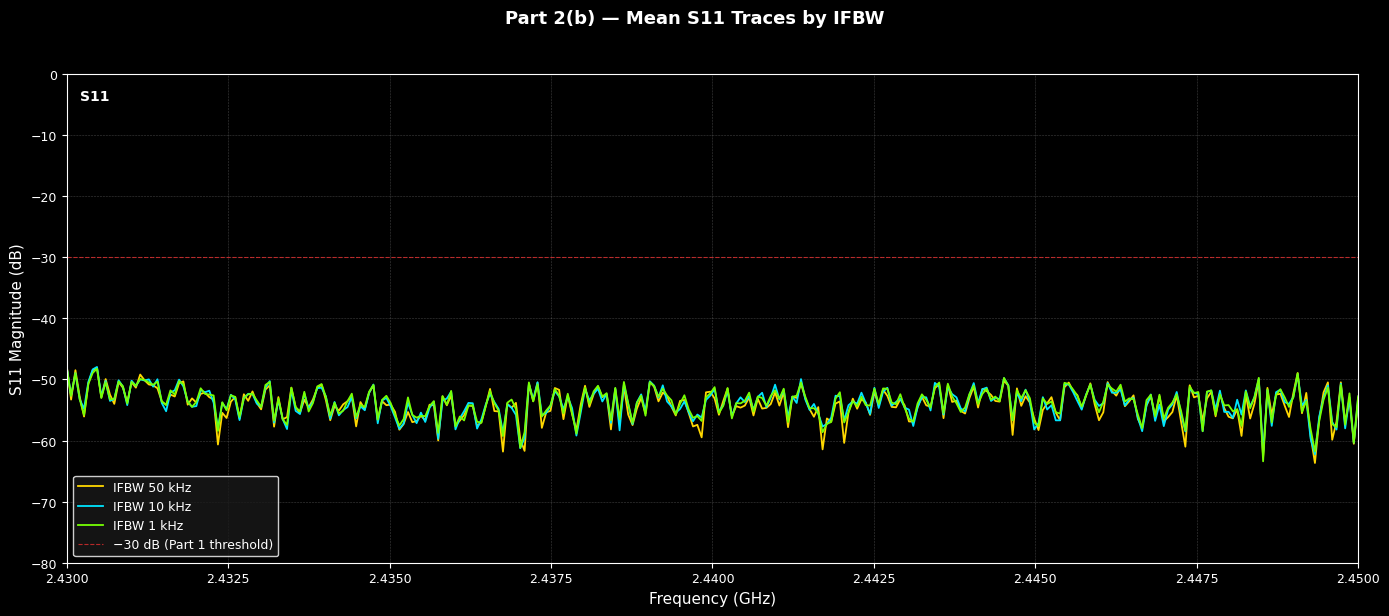

In [6]:
# ---------------------------------------------------------------------------
# Cell 8  --  Overlay plot: mean S11 by IFBW
# ---------------------------------------------------------------------------

plt.style.use("dark_background")

COLORS = {"50": "#FFD700", "10": "#00E5FF", "1": "#76FF03"}

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

for label in IFBW_LABELS:
    df = ifbw_traces[label]
    freq_ghz = df["Frequency_Hz"].to_numpy(dtype=np.float64) / 1e9

    # All sweep columns: Sweep_1_S11_dB, Sweep_2_S11_dB, ...
    sweep_cols = [c for c in df.columns if c.startswith("Sweep_")]
    s11_arr    = df[sweep_cols].to_numpy(dtype=np.float64)   # shape (300, N_sweeps)
    mean_s11   = np.mean(s11_arr, axis=1)                    # shape (300,)

    ax.plot(freq_ghz, mean_s11, color=COLORS[label], linewidth=1.3,
            label=f"IFBW {label} kHz")

# -30 dB reference from Part 1
ax.axhline(-30.0, color="#FF3333", linewidth=0.8, linestyle="--", alpha=0.7,
           label="\u221230 dB (Part 1 threshold)")

ax.set_xlim(2.430, 2.450)
ax.set_ylim(bottom=-80, top=0)
ax.set_xlabel("Frequency (GHz)", color="white", fontsize=11)
ax.set_ylabel("S11 Magnitude (dB)", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.legend(loc="lower left", fontsize=9,
          facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
ax.grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)

ax.text(0.01, 0.97, "S11", transform=ax.transAxes,
        color="white", fontsize=10, fontweight="bold", verticalalignment="top")

fig.suptitle("Part 2(b) — Mean S11 Traces by IFBW",
             color="white", fontsize=13, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()

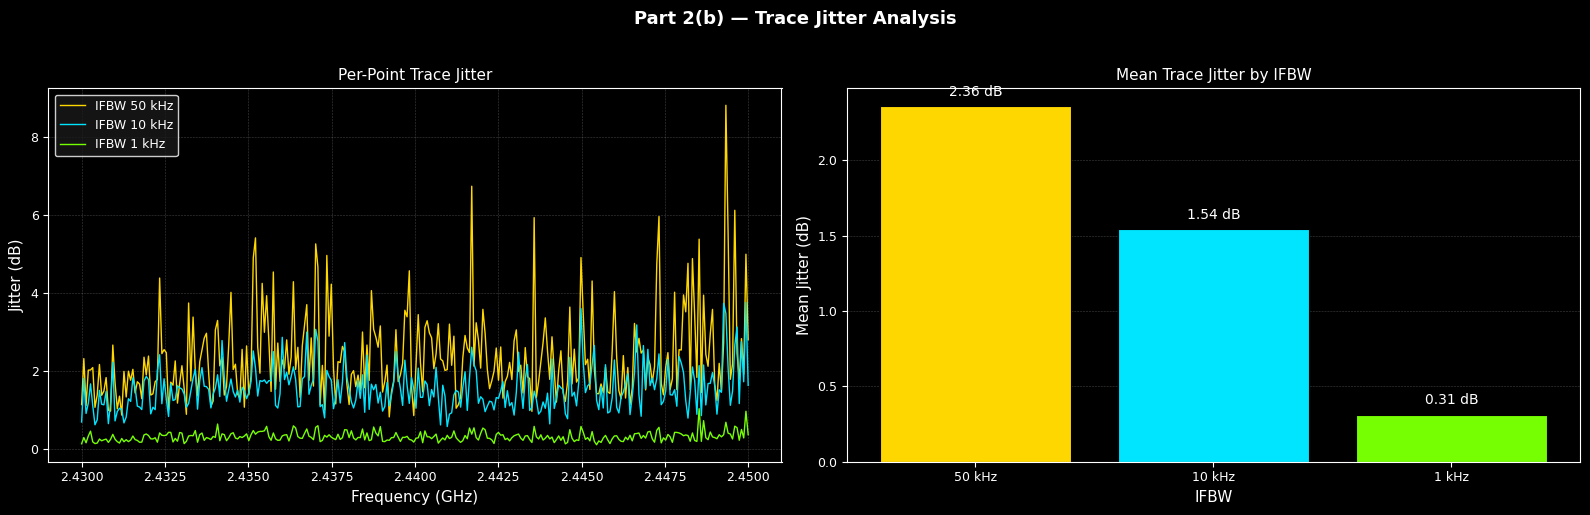

In [7]:
# ---------------------------------------------------------------------------
# Cell 9  --  Jitter analysis
# ---------------------------------------------------------------------------

plt.style.use("dark_background")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.patch.set_facecolor("black")
fig.suptitle("Part 2(b) — Trace Jitter Analysis",
             color="white", fontsize=13, fontweight="bold", y=1.02)

mean_jitters = {}   # label → float, for the bar chart

for label in IFBW_LABELS:
    df = ifbw_traces[label]
    freq_ghz   = df["Frequency_Hz"].to_numpy(dtype=np.float64) / 1e9
    sweep_cols = [c for c in df.columns if c.startswith("Sweep_")]
    s11_arr    = df[sweep_cols].to_numpy(dtype=np.float64)

    per_point_std = np.std(s11_arr, axis=1, ddof=1)   # shape (300,)
    mean_jitters[label] = float(np.mean(per_point_std))

    # ---- Left panel -------------------------------------------------------
    axes[0].plot(freq_ghz, per_point_std, color=COLORS[label], linewidth=1.0,
                 label=f"IFBW {label} kHz")

# Left panel style
axes[0].set_facecolor("black")
axes[0].set_xlabel("Frequency (GHz)", color="white", fontsize=11)
axes[0].set_ylabel("Jitter (dB)", color="white", fontsize=11)
axes[0].tick_params(colors="white", labelsize=9)
axes[0].legend(fontsize=9, facecolor="#1a1a1a", edgecolor="white", labelcolor="white")
axes[0].grid(True, color="white", linestyle="--", linewidth=0.4, alpha=0.25)
axes[0].set_axisbelow(True)
axes[0].set_title("Per-Point Trace Jitter", color="white", fontsize=11)

# ---- Right panel: bar chart -------------------------------------------
ax = axes[1]
ax.set_facecolor("black")

bar_labels = [f"{l} kHz" for l in IFBW_LABELS]
bar_values = [mean_jitters[l] for l in IFBW_LABELS]
bar_colors = [COLORS[l] for l in IFBW_LABELS]

bars = ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor="black", linewidth=0.8)

# Annotate each bar
for bar, val in zip(bars, bar_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
            f"{val:.2f} dB", ha="center", va="bottom", color="white", fontsize=10)

ax.set_xlabel("IFBW", color="white", fontsize=11)
ax.set_ylabel("Mean Jitter (dB)", color="white", fontsize=11)
ax.tick_params(colors="white", labelsize=9)
ax.grid(True, axis="y", color="white", linestyle="--", linewidth=0.4, alpha=0.25)
ax.set_axisbelow(True)
ax.set_title("Mean Trace Jitter by IFBW", color="white", fontsize=11)

plt.tight_layout()
plt.show()

In [8]:
# ---------------------------------------------------------------------------
# Cell 10  --  Part 2(b) comparison (PrettyTable)
# ---------------------------------------------------------------------------

# ---- Table 1: full comparison from summary CSV ----------------------------
t1 = PrettyTable()
t1.field_names = ["IFBW (kHz)", "Mean Sweep Time (s)", "Update Rate (Hz)",
                  "Noise Floor (dB)", "Trace Jitter (dB)"]
for _, row in df_summary.iterrows():
    t1.add_row([
        f"{int(row['IFBW_kHz'])}",
        f"{row['Mean_Sweep_Time_s']:.4f}",
        f"{row['Update_Rate_Hz']:.2f}",
        f"{row['Noise_Floor_dB']:.2f}",
        f"{row['Trace_Jitter_dB']:.4f}"
    ])
print("Part 2(b) — IFBW Comparison")
print(t1)

# ---- Table 2: ratios relative to 50 kHz baseline -------------------------
ref = df_summary[df_summary["IFBW_kHz"] == 50].iloc[0]
row_10 = df_summary[df_summary["IFBW_kHz"] == 10].iloc[0]
row_1  = df_summary[df_summary["IFBW_kHz"] == 1].iloc[0]

t2 = PrettyTable()
t2.field_names = ["Metric", "50 kHz \u2192 10 kHz", "50 kHz \u2192 1 kHz"]
t2.add_row([
    "Sweep Time Ratio",
    f"{row_10['Mean_Sweep_Time_s'] / ref['Mean_Sweep_Time_s']:.2f}x",
    f"{row_1['Mean_Sweep_Time_s'] / ref['Mean_Sweep_Time_s']:.2f}x"
])
t2.add_row([
    "Jitter Ratio",
    f"{row_10['Trace_Jitter_dB'] / ref['Trace_Jitter_dB']:.2f}x",
    f"{row_1['Trace_Jitter_dB'] / ref['Trace_Jitter_dB']:.2f}x"
])
print("\nRatios (relative to 50 kHz baseline)")
print(t2)

Part 2(b) — IFBW Comparison
+------------+---------------------+------------------+------------------+-------------------+
| IFBW (kHz) | Mean Sweep Time (s) | Update Rate (Hz) | Noise Floor (dB) | Trace Jitter (dB) |
+------------+---------------------+------------------+------------------+-------------------+
|     50     |        0.1953       |       5.12       |      -54.11      |       2.3598      |
|     10     |        0.2460       |       4.07       |      -53.83      |       1.5426      |
|     1      |        0.8094       |       1.24       |      -53.73      |       0.3111      |
+------------+---------------------+------------------+------------------+-------------------+

Ratios (relative to 50 kHz baseline)
+------------------+-----------------+----------------+
|      Metric      | 50 kHz → 10 kHz | 50 kHz → 1 kHz |
+------------------+-----------------+----------------+
| Sweep Time Ratio |      1.26x      |     4.14x      |
|   Jitter Ratio   |      0.65x      |     0.

## Combined Conclusions — Part 2  (after poll-interval fix)

### (a) Sweep Speed Baseline

The poll interval was reduced from 0.1 s to 0.01 s between the first
and second runs.  The two key effects:

1. **Bimodal artifact gone.**  Std dropped from 53.6 ms to 1.2 ms.
   The previous two-cluster distribution was caused entirely by the
   coarse `time.sleep()` — confirmed and eliminated.

2. **True pipeline latency exposed.**  Every sweep now lands at a
   consistent ~195 ms.  This is the LibreVNA-GUI SCPI sweep cycle time,
   not a host-side artifact.  It sets a hard floor of ~5.1 Hz through
   the current SCPI interface.

The 25 Hz target (≤ 40 ms/sweep) is not reachable via SCPI polling
alone.  The GUI internal overhead (~165 ms) dominates.

### (b) IFBW Parameter Sweep

The 0.01 s poll interval also corrected a measurement artefact in the
IFBW comparison.  With the old 0.1 s poll, 50 kHz and 10 kHz sweep
times were **indistinguishable** (~0.31 s vs ~0.32 s) because the
100 ms sleep quantised both into the same bin.  The new data resolves
them cleanly:

| IFBW | Sweep Time | Update Rate | Noise Floor | Trace Jitter |
|---|---|---|---|---|
| 50 kHz | 0.195 s | 5.12 Hz | −54.1 dB | 2.36 dB |
| 10 kHz | 0.246 s | 4.07 Hz | −53.8 dB | 1.54 dB |
| 1 kHz  | 0.809 s | 1.24 Hz | −53.7 dB | 0.31 dB |

| Observation | Detail |
|---|---|
| Sweep time vs IFBW | Now correctly resolved: 10 kHz is **1.26×** slower than 50 kHz; 1 kHz is **4.15×** slower.  The previous run could not distinguish 50 kHz from 10 kHz at all. |
| Noise floor | Essentially identical across all IFBWs (~−54 dB).  With a calibrated load this is expected: the value reflects the calibration residual, not the receiver noise bandwidth. |
| Trace jitter | Clear monotonic improvement: 50 kHz → 2.36 dB, 10 kHz → 1.54 dB, 1 kHz → 0.31 dB.  Narrower IFBW reduces receiver noise bandwidth and produces more repeatable traces. |
| Speed vs quality trade-off | Dropping from 50 kHz to 1 kHz improves jitter by **7.6×** at the cost of **4.15×** slower sweeps.  For applications where trace repeatability matters more than update rate, 1 kHz IFBW is the clear winner. |

### Vendor discussion points
1. **`time.sleep()` is confirmed as the source of the previously observed
   bimodal sweep-time distribution.**  Reducing the poll interval from
   0.1 s to 0.01 s eliminated it and cut mean sweep time by 35 %.
2. **The remaining bottleneck is inside LibreVNA-GUI**, not in the host
   polling loop.  ~165 ms of the 195 ms end-to-end sweep time is GUI
   internal overhead.  Reaching 25 Hz would require a direct USB
   interface or a firmware-level change to the sweep pipeline.
3. The jitter improvement with narrower IFBW follows textbook
   expectations and validates the ADC / DSP chain.
4. The noise floor being IFBW-independent (at this DUT) is a
   calibration-plane property; re-testing with an open or short
   standard would isolate the raw receiver noise floor.